## 1. Loading Library

In [1]:
import pandas as pd
import numpy as np
import math
import re
import time
from time import strftime
import datetime
import warnings #경고문 X
warnings.filterwarnings('ignore') # 경고문 X

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm ### 한글 폰트 깨지는 것 방지        
plt.rc('font', family='NanumGothic')
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False ###
# import matplotlib
# matplotlib.font_manager._rebuild() ### 최초 폰트 설치시 적용해야함
from itertools import cycle
import seaborn as sns
import mpl_finance as matfin

In [3]:
import sklearn

## 2. Loading Data
### KOSPI200_future_daily_data_20181217.csv

* KOSPI200에 대한 선물 관련 데이터
* 종목 : KOSPI200 선물
* 기간 : 2000/03/10 ~ 2018/12/27(주말 및 공휴일 제외 -> 거래일)
* 시기 : 장내 주간데이터(09:00~15:45) cf) 야간 데이터 제외

* KOSPI200 : KOSPI 상위 200개의 대형주의 주가를 지수화 시킨 주식 상품(선물과 옵션을 위해 만들어졌다)
* 선물 : 금융자산을 미리 결정된 가격으로 미래 일정시점에 인도·인수할 것을 약정한 거래

* 참고

    KOSPI200 https://ko.wikipedia.org/wiki/%EC%BD%94%EC%8A%A4%ED%94%BC200
    
    선물 : https://ko.wikipedia.org/wiki/%EC%84%A0%EB%AC%BC_(%EA%B8%88%EC%9C%B5)

* 변수 설명
        Unnamed: 1 : ???
        시가 : 장의 시작 가격
        고가 : 장의 최대 가격
        저가 : 장의 최소 가격
        종가 : 장의 종료 가격
        등락 : 종가의 등락 여부
        Unnamed: 8 : 종가 변화
        등락률 : 종가의 변화율
        거래량 : 당일 총 거래량
        미결제 : 선물 약정에 대한 현물 미결제량
        증감 : 미결제량의 변화
        거래대금 : (거래량 X 각 거래가격)의 합 (단위 : 백만원)
        코스피200 : 현물 종료 가격
        등락.1 : 현물 가격 등락 여부
        Unnamed: 16 : 현물 가격 변화
        K200업종코드 : 코드
        Basis : 선물 종가 - 현물 종가

In [4]:
df = pd.read_csv('data/KOSPI200_future_daily_data_20181217.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644 entries, 0 to 4643
Data columns (total 19 columns):
일자             4643 non-null object
Unnamed: 1     0 non-null float64
종목             4643 non-null object
시가             4643 non-null float64
고가             4643 non-null float64
저가             4643 non-null float64
종가             4643 non-null float64
등락             4584 non-null object
Unnamed: 8     4643 non-null float64
등락률            4643 non-null float64
거래량            4643 non-null object
미결제            4643 non-null object
증감             4643 non-null object
거래대금           4643 non-null object
코스피200         4642 non-null float64
등락.1           4620 non-null object
Unnamed: 16    4642 non-null float64
K200업종코드       4643 non-null float64
Basis          4643 non-null float64
dtypes: float64(11), object(8)
memory usage: 689.4+ KB


cf) https://brunch.co.kr/@futureshiri/12 # Basis

In [5]:
df.head()

일자  Unnamed: 1     종목      시가      고가      저가      종가 등락  \
0  2018/12/27         NaN  101P3  261.45  262.35  260.40  261.50  ▲   
1  2018/12/26         NaN  101P3  257.90  259.50  256.15  257.30  ▼   
2  2018/12/24         NaN  101P3  261.00  261.60  259.80  261.55  ▼   
3  2018/12/21         NaN  101P3  261.30  262.00  260.35  261.65  ▲   
4  2018/12/20         NaN  101P3  262.75  263.30  260.20  261.45  ▼   

   Unnamed: 8   등락률      거래량      미결제      증감        거래대금  코스피200 등락.1  \
0        4.20  1.63  160,890  287,143     435  10,522,408     NaN  NaN   
1        4.25 -1.62  247,208  286,708   6,125  15,933,806  260.98    ▼   
2        0.10 -0.04  129,083  280,583  -1,508   8,422,109  264.45    ▼   
3        0.20  0.08  138,490  282,091  -1,202   9,048,134  265.06    ▲   
4        3.00 -1.13  264,081  283,293    -924  17,280,001  264.81    ▼   

   Unnamed: 16  K200업종코드   Basis  
0          NaN    2101.0  261.50  
1         3.47    2101.0   -3.68  
2         0.61    2101.0   -2.90  
3         0.25    2101.0   -3.41  
4         2.50    2101.0   -3.36

## 3. Data Preprocessing & EDA
* 데이터의 문제 해결을 위해 전처리를 시행
* 필요 없는 변수 및 데이터 제거
* 분석에 필요한 파생변수 생성
* 시각화 및 데이터 분석

### NA 처리 및 데이터 정리

In [7]:
# missing value 표시기
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})

missing['percent'] = missing['total'] / len(df)

missing.sort_values('percent', ascending = False).head(10)

total   percent
Unnamed: 1    4644  1.000000
등락              60  0.012920
등락.1            24  0.005168
Unnamed: 16      2  0.000431
코스피200           2  0.000431
일자               1  0.000215
미결제              1  0.000215
K200업종코드         1  0.000215
거래대금             1  0.000215
증감               1  0.000215

In [6]:
# Unnamed:1 col은 전부 NaN이고, 종목은 동일한 KOSPI200이기 때문에 col 제거
# 시작할때 시가, 마지막 데이터의 현물의 종가가 없기 때문에 해당 row 제거
df = df.drop(df.columns[[1,2,-2]], 1)
df = df.drop([0, 4643],0)

In [7]:
df['거래량'] = df['거래량'].apply(lambda x: re.sub(',', '', x))
df['미결제'] = df['미결제'].apply(lambda x: re.sub(',', '', x))
df['증감'] = df['증감'].apply(lambda x: re.sub(',', '', x))
df['거래대금'] = df['거래대금'].apply(lambda x: re.sub(',', '', x))
df.loc[df['등락'] == '↓', "등락"] = -2 # 10보다 큰 수치만큼 하락
df.loc[df['등락'] == '▼', "등락"] = -1 # 하락
df.loc[df['등락'] == '▲', "등락"] = 1
df.loc[df['등락'] == '↑', "등락"] = 2
df.loc[df['등락.1'] == '↓', "등락.1"] = -2
df.loc[df['등락.1'] == '▼', "등락.1"] = -1
df.loc[df['등락.1'] == '▲', "등락.1"] = 1
df.loc[df['등락.1'] == '↑', "등락.1"] = 2
df['등락'].fillna(0, inplace=True)
df['등락.1'].fillna(0, inplace=True)

In [8]:
df['거래량'] = df['거래량'].astype('int')
df['미결제'] = df['미결제'].astype('int')
df['증감'] = df['증감'].astype('int')
df['거래대금'] = df['거래대금'].astype('float64')
df['등락'] = df['등락'].astype('int')
df['등락.1'] = df['등락.1'].astype('int')

In [9]:
# 불분명한 변수명 변경
df.rename(columns={'Unnamed: 8': '종가변화', 'Unnamed: 16': '현물변화', '등락.1' : '현물등락'}, inplace=True)
df['종가변화'] = df['종가변화'] * df['등락'] # 종가변화 부호 고려

In [9]:
df.head()

일자      시가     고가      저가      종가  등락  종가변화   등락률     거래량     미결제  \
1  2018/12/26  257.90  259.5  256.15  257.30  -1 -4.25 -1.62  247208  286708   
2  2018/12/24  261.00  261.6  259.80  261.55  -1 -0.10 -0.04  129083  280583   
3  2018/12/21  261.30  262.0  260.35  261.65   1  0.20  0.08  138490  282091   
4  2018/12/20  262.75  263.3  260.20  261.45  -1 -3.00 -1.13  264081  283293   
5  2018/12/19  263.40  264.7  262.65  264.45   1  1.90  0.72  162682  284217   

     증감        거래대금  코스피200  현물등락  현물변화  Basis  
1  6125  15933806.0  260.98    -1  3.47  -3.68  
2 -1508   8422109.0  264.45    -1  0.61  -2.90  
3 -1202   9048134.0  265.06     1  0.25  -3.41  
4  -924  17280001.0  264.81    -1  2.50  -3.36  
5  3419  10734519.0  267.31     1  2.13  -2.86

In [10]:
# 날짜 변환후 indexing
df['일자'] = pd.to_datetime(df['일자'], format = '%Y/%m/%d')
df['연도'] = df['일자'].dt.year
df['월'] = df['일자'].dt.month
df['일'] = df['일자'].dt.day
df['요일'] = df['일자'].dt.weekday # 0~6(월~일)
df = df.set_index('일자')
df = df.sort_values(["일자"], ascending=[True])

### 파생변수 생성

In [11]:
# Moving Average(이동평균선)
df['5MA'] = df['종가'].rolling(window = 5, min_periods = 1).mean()
df['10MA'] = df['종가'].rolling(window = 10, min_periods = 1).mean()
df['15MA'] = df['종가'].rolling(window = 15, min_periods = 1).mean()
df['20MA'] = df['종가'].rolling(window = 20, min_periods = 1).mean()
df['25MA'] = df['종가'].rolling(window = 25, min_periods = 1).mean()
df['30MA'] = df['종가'].rolling(window = 30, min_periods = 1).mean()
df['35MA'] = df['종가'].rolling(window = 35, min_periods = 1).mean()
df['40MA'] = df['종가'].rolling(window = 40, min_periods = 1).mean()
df['45MA'] = df['종가'].rolling(window = 45, min_periods = 1).mean()
df['50MA'] = df['종가'].rolling(window = 50, min_periods = 1).mean()
df['55MA'] = df['종가'].rolling(window = 55, min_periods = 1).mean()
df['60MA'] = df['종가'].rolling(window = 60, min_periods = 1).mean()

In [12]:
# Bollinger Band
N = 20 # 기간
s = 2 # s표준편차 -> 95%
S = df['종가'].rolling(window=N, min_periods=1).std() # 표준편차
S.fillna(method='bfill', inplace=True)

df['BB_M'] = df['종가'].rolling(window=N, min_periods=1).mean()
df['BB_L'] = df['BB_M'] + S*s
df['BB_H'] = df['BB_M'] - S*s

In [13]:
# ATR(14일 기준 가격변동폭)

HL = df['고가'] - df['저가']
HM = abs(df['종가'].shift(1).fillna(112.5) - df['고가'])
LM = abs(df['종가'].shift(1).fillna(112.5) - df['저가'])

df['ATR'] = pd.Series([])

for i in range(0, len(HL)) :
    df['ATR'][i] = max(HL[i], HM[i], LM[i])

In [14]:
# Stochastic(일반적으로 Fast는 10,5 / Slow는 10,5,5를 많이 이용)
def Sto_Fast(d, t) :
    K_max = df['종가'].rolling(window=d, min_periods=1).max()
    K_min = df['종가'].rolling(window=d, min_periods=1).min()
    K = df['종가'] / (K_max - K_min)
    K = K.replace(np.inf, np.nan)
    D = K.rolling(window=t, min_periods=1).mean()
    K.fillna(0, inplace=True)
    D.fillna(0, inplace=True)
    return K, D

def Sto_Slow(d, t, T) :
    K_max = df['종가'].rolling(window=d, min_periods=1).max()
    K_min = df['종가'].rolling(window=d, min_periods=1).min()
    K = df['종가'] / (K_max - K_min).rolling(window=t, min_periods=1).mean()
    K = K.replace(np.inf, np.nan)
    D = K.rolling(window=T, min_periods=1).mean()
    K.fillna(0, inplace=True)
    D.fillna(0, inplace=True)
    return K, D

In [15]:
fast_K, fast_D = Sto_Fast(10, 5)
slow_K, slow_D = Sto_Slow(10, 5, 5)

In [16]:
df['fast_K'] = fast_K
df['fast_D'] = fast_D
df['slow_K'] = slow_K
df['slow_D'] = slow_D

In [20]:
df.head().transpose()

일자        2000-03-10    2000-03-13    2000-03-14    2000-03-15    2000-03-16
시가      1.145000e+02  1.100000e+02  1.038000e+02  1.024000e+02  1.070000e+02
고가      1.148500e+02  1.100000e+02  1.061500e+02  1.060000e+02  1.078500e+02
저가      1.115000e+02  1.038000e+02  1.034000e+02  1.003000e+02  1.039500e+02
종가      1.116000e+02  1.038000e+02  1.050000e+02  1.060000e+02  1.055000e+02
등락     -1.000000e+00 -1.000000e+00  1.000000e+00  1.000000e+00 -1.000000e+00
종가변화   -9.000000e-01 -7.800000e+00  1.200000e+00  1.000000e+00 -5.000000e-01
등락률    -8.000000e-01 -6.990000e+00  1.160000e+00  9.500000e-01 -4.700000e-01
거래량     5.365400e+04  5.189400e+04  5.798800e+04  6.630800e+04  5.900800e+04
미결제     1.833600e+04  1.797000e+04  1.911200e+04  2.471200e+04  2.611000e+04
증감      1.833600e+04 -3.660000e+02  1.142000e+03  5.600000e+03  1.398000e+03
거래대금    3.026661e+06  2.753537e+06  3.039295e+06  3.400235e+06  3.119567e+06
코스피200  1.106800e+02  1.051400e+02  1.043000e+02  1.032800e+02  1.041900e+02
현물등락    1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00  1.000000e+00
현물변화    8.700000e-01  5.540000e+00  8.400000e-01  1.020000e+00  9.100000e-01
Basis   9.200000e-01 -1.340000e+00  7.000000e-01  2.720000e+00  1.310000e+00
연도      2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03
월       3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00
일       1.000000e+01  1.300000e+01  1.400000e+01  1.500000e+01  1.600000e+01
요일      4.000000e+00  0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00
5MA     1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
10MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
15MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
20MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
25MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
30MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
35MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
40MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
45MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
50MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
55MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
60MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
BB_M    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
BB_L    1.226309e+02  1.187309e+02  1.152000e+02  1.135051e+02  1.124404e+02
BB_H    1.005691e+02  9.666913e+01  9.840000e+01  9.969493e+01  1.003196e+02
ATR     3.350000e+00  7.800000e+00  2.750000e+00  5.700000e+00  3.900000e+00
fast_K  0.000000e+00  1.330769e+01  1.346154e+01  1.358974e+01  1.352564e+01
fast_D  0.000000e+00  1.330769e+01  1.338462e+01  1.345299e+01  1.347115e+01
slow_K  0.000000e+00  2.661538e+01  2.019231e+01  1.811966e+01  1.690705e+01
slow_D  0.000000e+00  2.661538e+01  2.340385e+01  2.164245e+01  2.045860e+01

### EDA

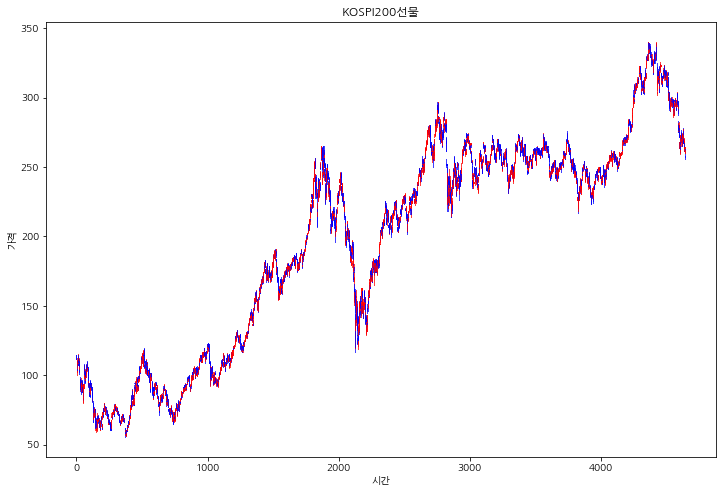

In [21]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
matfin.candlestick2_ohlc(ax, df['시가'], df['고가'], df['저가'], df['종가'], width=0.5, colorup='r', colordown='b')

plt.title("KOSPI200선물")
plt.xlabel('시간')
plt.ylabel('가격')

plt.show()

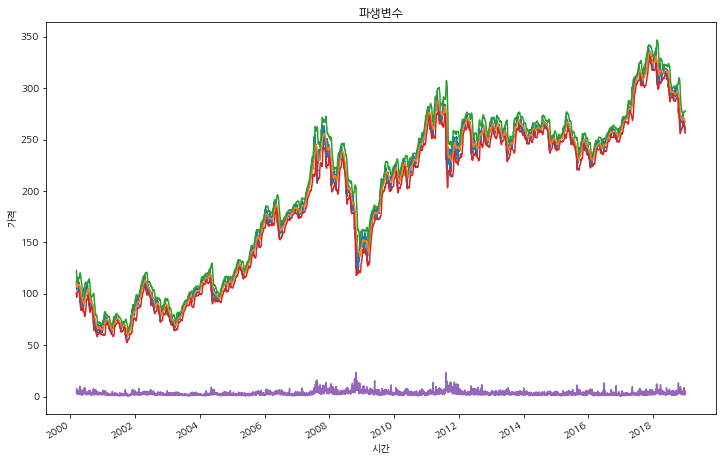

In [22]:
plt.figure(figsize=(12,8))
df['종가'].plot()
df['BB_M'].plot()
df['BB_L'].plot()
df['BB_H'].plot()
df['ATR'].plot()
plt.title("파생변수")
plt.xlabel('시간')
plt.ylabel('가격')
plt.show()

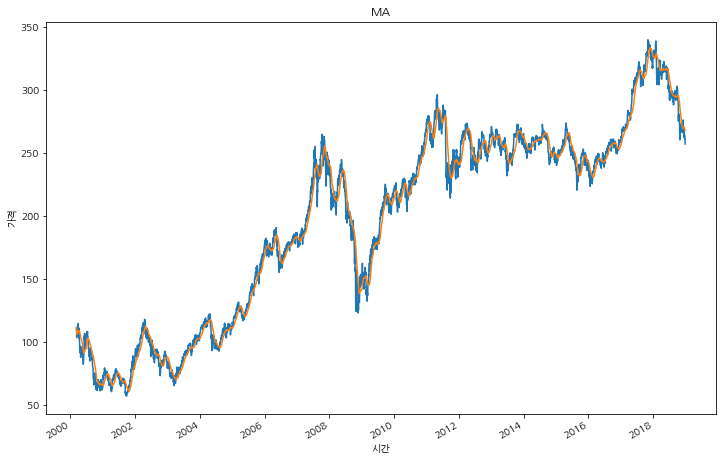

In [22]:
plt.figure(figsize=(12,8))

df['종가'].plot()
df['30MA'].plot()

plt.title("MA")
plt.xlabel('시간')
plt.ylabel('가격')
plt.show()

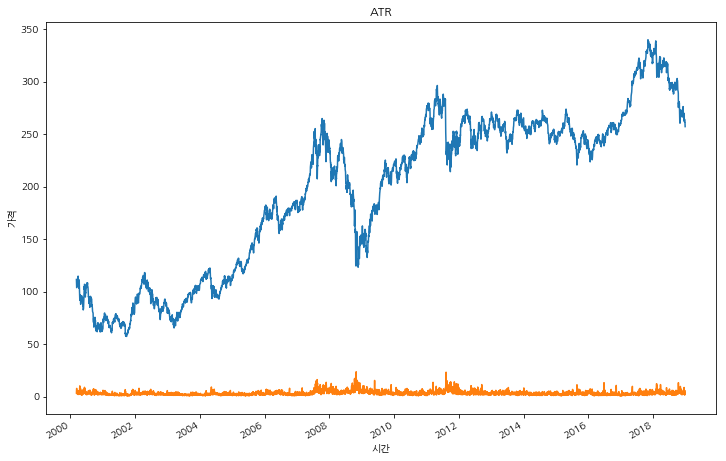

In [16]:
plt.figure(figsize=(12,8))

df['종가'].plot()
df['ATR'].plot()

plt.title("ATR")
plt.xlabel('시간')
plt.ylabel('가격')
plt.show()

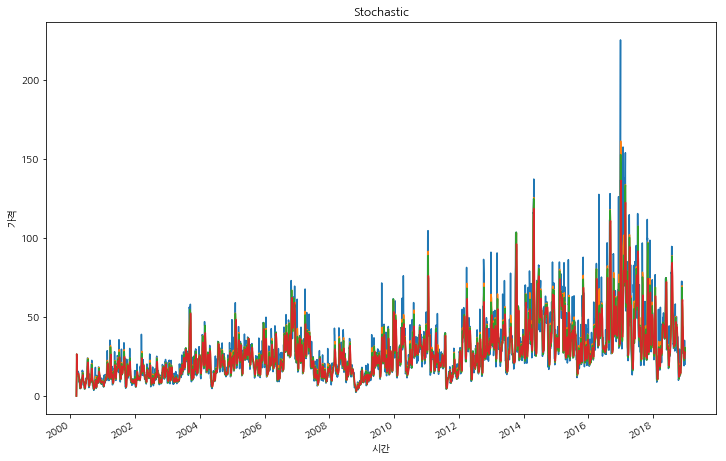

In [18]:
plt.figure(figsize=(12,8))

df['fast_K'].plot()
df['fast_D'].plot()
df['slow_K'].plot()
df['slow_D'].plot()

plt.title("Stochastic")
plt.xlabel('시간')
plt.ylabel('가격')
plt.show()

In [23]:
# 시각화(시장 및 파생변수 모두 고려)

import plotly.offline as offline 
import plotly.graph_objs as go 

# jupyterlab에서 출력 

trace0 = go.Candlestick(x=df.index, open=df.시가, high=df.고가, low=df.저가, close=df.종가, name='candlestick') 
trace1 = go.Scatter(x=df.index, y=df.ATR, name='ATR', mode='lines')
trace2 = go.Scatter(x=df.index, y=df.BB_M, name='Bollinger Band_M', mode='lines', line=dict(color='rgb(0,100,80)'))
trace3 = go.Scatter(x=df.index, y=df.BB_H, name='Bollinger Band_H', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')
trace4 = go.Scatter(x=df.index, y=df.BB_L, name='Bollinger Band_L', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')
trace5 = go.Bar(x=df.index, y=df.거래량, name='Revenue', 
                marker=dict(color='rgb(158,202,225)', line=dict(color='rgb(8,48,107)', width=1.5)), opacity=0.3, yaxis='y2')

data = [trace0, trace1, trace2, trace3, trace4, trace5] 

layout = go.Layout(title='KOSPI200 선물지수', 
                   yaxis=dict(title='price'),
                   yaxis2=dict(title='revenue',titlefont=dict(color='rgb(148, 103, 189)'),tickfont=dict(color='rgb(148, 103, 189)'),
                               overlaying='y',side='right')
                  )

fig = go.Figure(data=data, layout=layout) 
offline.plot(fig, filename="KOSPI200_future.html")

'file://C:\\Users\\veror\\Documents\\multi_proj\\I9_팀프로젝트\\G3\\G32_금융_파생상품中선물분석\\KOSPI200_future.html'

In [17]:
# 시각화(시장 및 파생변수 모두 고려)

import plotly.offline as offline 
import plotly.graph_objs as go 

# jupyterlab에서 출력 

trace0 = go.Candlestick(x=df.index, open=df.시가, high=df.고가, low=df.저가, close=df.종가, name='candlestick') 
trace2 = go.Scatter(x=df.index, y=df.BB_M, name='Bollinger Band_M', mode='lines', line=dict(color='rgb(0,100,80)'))
trace3 = go.Scatter(x=df.index, y=df.BB_H, name='Bollinger Band_H', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')
trace4 = go.Scatter(x=df.index, y=df.BB_L, name='Bollinger Band_L', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')

data = [trace0, trace2, trace3, trace4] 

layout = go.Layout(title='KOSPI200 선물 Bollinger Band', 
                   yaxis=dict(title='price'),
                   yaxis2=dict(title='revenue',titlefont=dict(color='rgb(148, 103, 189)'),tickfont=dict(color='rgb(148, 103, 189)'),
                               overlaying='y',side='right')
                  )

fig = go.Figure(data=data, layout=layout) 
offline.plot(fig, filename="BollingerBand.html")

'file://C:\\Users\\veror\\Documents\\multi_proj\\I9_팀프로젝트\\G3\\G32_금융_파생상품中선물분석\\BollingerBand.html'

In [24]:
# jupyterlab에서 출력 

trace0 = go.Candlestick(x=df.index, open=df.시가, high=df.고가, low=df.저가, close=df.종가, name='candlestick') 
trace2 = go.Scatter(x=df.index, y=df['30MA'], name='30MA', mode='lines', line=dict(color='rgb(0,100,80)'))

data = [trace0, trace2] 

layout = go.Layout(title='KOSPI200 선물 30MA', 
                   yaxis=dict(title='price'),
                   yaxis2=dict(title='revenue',titlefont=dict(color='rgb(148, 103, 189)'),tickfont=dict(color='rgb(148, 103, 189)'),
                               overlaying='y',side='right')
                  )

fig = go.Figure(data=data, layout=layout) 
offline.plot(fig, filename="30MA.html")

'file://C:\\Users\\veror\\Documents\\multi_proj\\I9_팀프로젝트\\G3\\G32_금융_파생상품中선물분석\\30MA.html'

In [107]:
# jupyter notebook에서 출력 

offline.init_notebook_mode(connected=True) # jupyterlab에서 실행시 해당 부분 삭제하고 마지막 부분 iplot->plot으로 변경
trace0 = go.Candlestick(x=df.index, open=df.시가, high=df.고가, low=df.저가, close=df.종가, name='candlestick') 
trace1 = go.Scatter(x=df.index, y=df.ATR, name='ATR', mode='lines')
trace2 = go.Scatter(x=df.index, y=df.BB_M, name='Bollinger Band_M', mode='lines', line=dict(color='rgb(0,100,80)'))
trace3 = go.Scatter(x=df.index, y=df.BB_H, name='Bollinger Band_H', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')
trace4 = go.Scatter(x=df.index, y=df.BB_L, name='Bollinger Band_L', line=dict(color='rgba(255,255,255,0)'), fill='tonexty', fillcolor='rgba(0,100,80,0.2)')
trace5 = go.Bar(x=df.index, y=df.거래량, name='Revenue', 
                marker=dict(color='rgb(158,202,225)', line=dict(color='rgb(8,48,107)', width=1.5)), opacity=0.3, yaxis='y2')

data = [trace0, trace1, trace2, trace3, trace4, trace5] 

layout = go.Layout(title='KOSPI200 선물지수', 
                   yaxis=dict(title='price'),
                   yaxis2=dict(title='revenue',titlefont=dict(color='rgb(148, 103, 189)'),tickfont=dict(color='rgb(148, 103, 189)'),
                               overlaying='y',side='right')
                  )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename="KOSPI200_future.html")

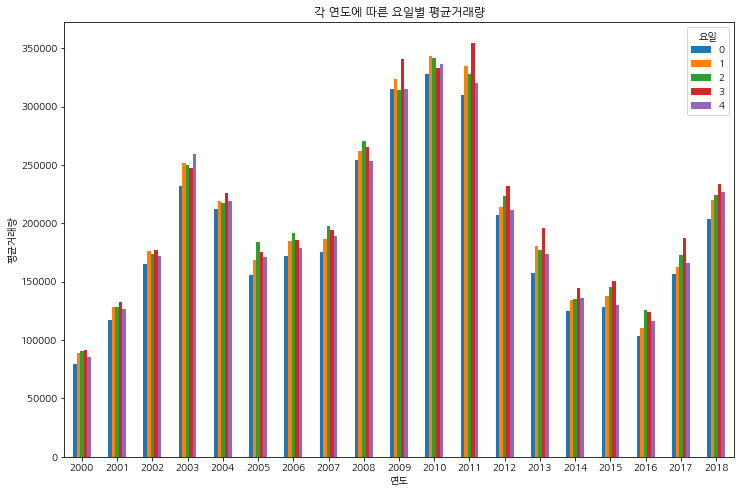

In [24]:
tv = df['거래량'].groupby([df['요일'], df['연도']]).mean().unstack('연도')
tv.T.plot.bar(rot=0, figsize=(12,8))
plt.title("각 연도에 따른 요일별 평균거래량")
plt.xlabel("연도")
plt.ylabel("평균거래량")
plt.show()

* 차이는 크지 않지만 상대적으로 월요일과 금요일에 거래량이 적은 것을 확인할 수 있다.
* 2009년부터 2011년 사이에 거래량이 집중되는 것을 확인할 수 있다.
* 거래량 -> 시장의 변동성
* 유추해볼 수 있는 점은 금융위기로 시장의 불안정함에 따라 많은 거래가 이루어진 것을 확인 할 수있다.
* 2011년 이후로 시장이 안정되다가 2018년에 이르러서 불안정해지고 있는 것을 확인할 수 있다.

In [25]:
df.loc[df['요일']==0, '종가'].groupby(df['연도']).mean()

연도
2000     86.578947
2001     71.203000
2002     94.624000
2003     87.550980
2004    107.658163
2005    137.482292
2006    175.523958
2007    219.890816
2008    196.358163
2009    186.340196
2010    231.409000
2011    261.628125
2012    255.080612
2013    257.879412
2014    256.401000
2015    248.607000
2016    247.327083
2017    301.811702
2018    300.717347
Name: 종가, dtype: float64

## 4-1. Regression
* 본격적인 예측 모델에 앞서 변수 간의 상관관계를 파악한다.
* '종가' 를 타겟으로 지정하기에 앞서, 회귀 분석을 통해 '종가' 에 대한 다른 변수들의 영향력을 확인한다.

In [17]:
df_reg = df

In [18]:
df_reg.columns

Index(['시가', '고가', '저가', '종가', '등락', '종가변화', '등락률', '거래량', '미결제', '증감', '거래대금',
       '코스피200', '현물등락', '현물변화', 'Basis', '연도', '월', '일', '요일', '5MA', '10MA',
       '15MA', '20MA', '25MA', '30MA', '35MA', '40MA', '45MA', '50MA', '55MA',
       '60MA', 'BB_M', 'BB_L', 'BB_H', 'ATR', 'fast_K', 'fast_D', 'slow_K',
       'slow_D'],
      dtype='object')

In [24]:
df_cor = df_reg.drop(['10MA', '15MA', '20MA', '25MA', '30MA', '35MA', '40MA', '45MA', '50MA', '55MA', '60MA', 'BB_M', 'BB_L', 'BB_H'], axis=1) # 종가 = 코스피200 - Basis

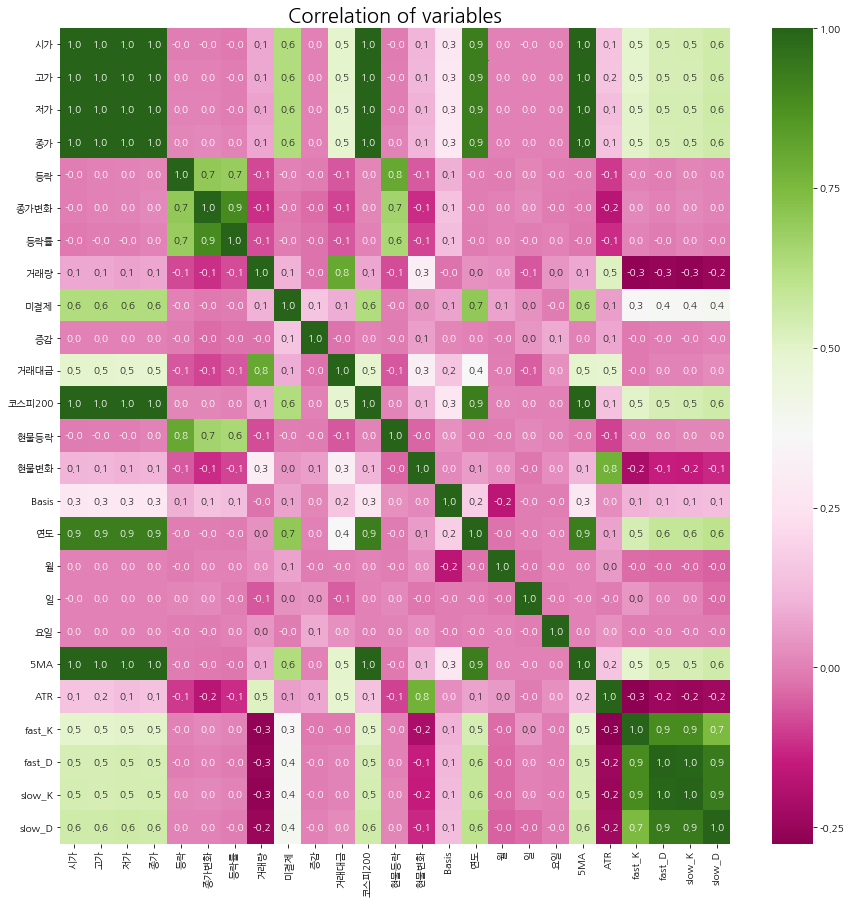

In [25]:
plt.figure(figsize=(15,15))
plt.title('Correlation of variables', fontsize=20)
sns.heatmap(df_cor.corr().astype(float),annot=True, cmap ="PiYG",vmax=1.0,fmt='.1f')
plt.show()

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_cor.values, i) for i in range(df_cor.shape[1])]
vif["features"] = df_cor.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

VIF Factor features
0   1.138195e+00       증감
1   3.051250e+00       요일
2   3.095112e+00     현물등락
3   3.406618e+00       등락
4   4.475887e+00        일
5   4.918786e+00        월
6   5.306032e+00      등락률
7   6.717626e+00     현물변화
8   7.389532e+00     종가변화
9   2.471782e+01   fast_K
10  2.492359e+01      미결제
11  4.201440e+01      ATR
12  4.767871e+01       연도
13  5.396819e+01   slow_D
14  6.625448e+01     거래대금
15  7.672441e+01      거래량
16  3.841772e+02   slow_K
17  3.927088e+02   fast_D
18  1.340004e+04      5MA
19  7.325597e+04       시가
20  1.542488e+05       저가
21  1.622392e+05       고가
22           inf    Basis
23           inf   코스피200
24           inf       종가

In [ ]:
### VIF 값이 10 이하인 변수는 증감, 요일, 현물등락, 등락, 일, 월, 등락률, 현물변화, 종가변화 정도가 있다.

### Linear Regression

In [24]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split 
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge 
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  
from xgboost import XGBRegressor, plot_importance 
from sklearn.svm import SVR, SVC, LinearSVC 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import KernelPCA, PCA 
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV 
from sklearn.base import clone 
from sklearn.metrics import mean_squared_error, r2_score

X_train: (3250, 39)
y_train: (3250,)
X_test: (1392, 39)
y_test: (1392,)


선형회귀 분석 결과
lr.coef_: [-1.08663705e-03  1.61354529e-01  1.01822707e-01  3.95523495e-01
  9.28312742e-02  8.57411150e-02 -5.66466552e-02  1.98450760e-06
 -3.95263634e-06  8.74550662e-07 -2.59525033e-08  3.14078959e-01
  2.15456777e-02  2.15356658e-02  8.14445364e-02  1.11709128e-01
  3.69387441e-03  1.20901933e-02 -3.38552972e-02  1.19904281e-02
  7.84626071e-02 -1.38855570e-01  1.45098700e-02  1.58031289e-01
 -1.83110536e-01 -1.68364424e-01  5.11053851e-01 -2.37002684e-01
 -4.29968141e-01  4.95545296e-01 -1.30482817e-01  1.45098700e-02
  2.24906190e-02  6.52912099e-03 -4.62694426e-03  5.58246886e-03
 -1.10395311e-01  9.84545877e-02  2.29575792e-02]
계수 해당 변수 확인
Index(['시가', '고가', '저가', '종가', '등락', '종가변화', '등락률', '거래량', '미결제', '증감', '거래대금',
       '코스피200', '현물등락', '현물변화', 'Basis', '연도', '월', '일', '요일', '5MA', '10MA',
       '15MA', '20MA', '25MA', '30MA', '35MA', '40MA', '45MA', '50MA', '55MA',
       '60MA', 'BB_M

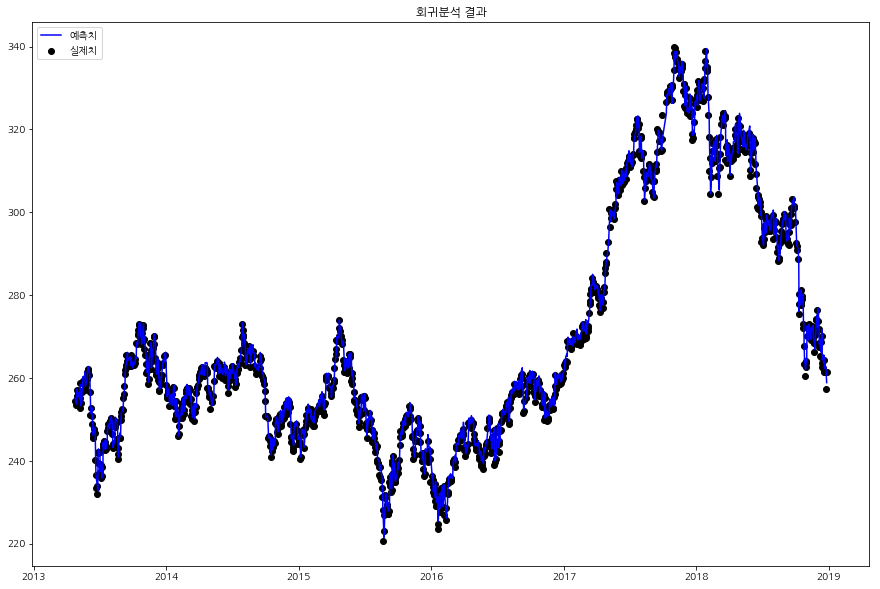

In [63]:
### 독립변수간 상관관계를 볼 때 다중공선성이 있지만 종가예측 값을 대상으로 먼저 회귀분석을 해봅니다.

df_reg['종가예측'] = df['종가'].shift(-1)
df_reg['종가예측'].fillna(261.5, inplace = True)
X = df_reg.drop(['종가예측'], axis=1)
y = df_reg['종가예측']

X_train = X[:3250] # 전체 rows의 70퍼센트
X_test = X[3250:]
y_train = y[:3250]
y_test = y[3250:]

print("X_train: {}".format(str(X_train.shape))+'\n'+
      "y_train: {}".format(str(y_train.shape))+'\n'+
      "X_test: {}".format(str(X_test.shape))+'\n'+
      "y_test: {}".format(str(y_test.shape)))
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('\n')
print('선형회귀 분석 결과')
print("lr.coef_: {}".format(lr.coef_))
print('계수 해당 변수 확인')
print(X.columns)
print('\n')
print("lr.intercept_: {}".format(lr.intercept_))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print('\n')
print("훈련 세트 점수: {:.2f}".format(lr.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lr.score(X_test, y_test)))
print('\n')
plt.figure(figsize=(15,10))
plt.scatter(X_test.index, y_test,  color='black', label = '실제치')
plt.plot(X_test.index, y_pred, color='blue', label = '예측치')
plt.title("회귀분석 결과")
plt.legend(loc=2)
plt.show()

In [29]:
### 조건수가 많아 과최적화가 발생한 것을 확인 -> 먼저 scale
x = scale(X);X

시가      고가      저가  등락   종가변화    등락률     거래량     미결제      증감  \
일자                                                                             
2000-03-10  114.50  114.85  111.50  -1  -0.90  -0.80   53654   18336   18336   
2000-03-13  110.00  110.00  103.80  -1  -7.80  -6.99   51894   17970    -366   
2000-03-14  103.80  106.15  103.40   1   1.20   1.16   57988   19112    1142   
2000-03-15  102.40  106.00  100.30   1   1.00   0.95   66308   24712    5600   
2000-03-16  107.00  107.85  103.95  -1  -0.50  -0.47   59008   26110    1398   
2000-03-17  109.95  109.95  106.30   1   1.20   1.14   55695   23867   -2243   
2000-03-20  107.65  109.50  106.30   1   0.05   0.05   44985   25317    1450   
2000-03-21  105.50  109.60  105.30   1   2.45   2.30   51925   27162    1845   
2000-03-22  109.20  112.55  109.00   1   1.60   1.47   54973   27634     472   
2000-03-23  111.30  112.30  108.45  -1  -2.20  -1.99   50439   25186   -2448   
2000-03-24  109.60  114.05  108.60   1   3.95   3.64   54861   26648    1462   
2000-03-27  112.55  112.70  109.90  -1  -0.85  -0.76   49813   25745    -903   
2000-03-28  111.70  114.50  111.20   1   1.00   0.90   49385   26726     981   
2000-03-29  110.50  115.55  110.25   1   2.10   1.86   50721   28284    1558   
2000-03-30  114.50  114.95  113.00  -1  -1.80  -1.57   49664   26257   -2027   
2000-03-31  111.50  112.80  109.20  -1  -3.00  -2.65   45422   28512    2255   
2000-04-03  111.00  111.70  106.90  -1  -2.45  -2.23   50053   29886    1374   
2000-04-04  107.55  108.55  104.35  -1  -1.00  -0.93   60247   34336    4450   
2000-04-06  106.05  106.40  102.90  -1  -3.25  -3.05   51219   33128   -1208   
2000-04-07  104.95  107.10  104.00   1   3.40   3.29   50488   32558    -570   
2000-04-10  108.15  112.30  108.00   1   4.50   4.22   53689   33454     896   
2000-04-11  110.00  110.10  107.45  -1  -2.85  -2.56   46562   33706     252   
2000-04-12  107.90  108.80  106.50  -1  -1.45  -1.34   46485   30686   -3020   
2000-04-14  103.45  103.45  100.80  -1  -4.85  -4.54   38429   30118    -568   
2000-04-17   93.00   94.80   91.85  -1 -10.20 -10.00   38608   37085    6967   
2000-04-18   95.05   96.70   92.30   1   2.35   2.56   69649   33207   -3878   
2000-04-19   97.20   98.50   94.20   1   0.80   0.85   66912   31540   -1667   
2000-04-20   94.00   96.65   93.70   1   1.35   1.42   54644   32750    1210   
2000-04-21   97.00   97.50   95.45   1   0.60   0.62   46417   33053     303   
2000-04-24   96.50   96.50   92.40  -1  -4.55  -4.69   49838   33915     862   
...            ...     ...     ...  ..    ...    ...     ...     ...     ...   
2018-11-14  269.90  270.30  268.30  -1  -0.10  -0.04  182857  332600    1999   
2018-11-15  268.70  272.30  267.90   1   2.80   1.04  249002  335312    2712   
2018-11-16  272.90  273.60  271.25  -1  -0.40  -0.15  244104  335399      87   
2018-11-19  271.80  274.40  271.25   1   0.90   0.33  209419  336030     631   
2018-11-20  269.65  271.10  269.00  -1  -3.00  -1.10  217123  333086   -2944   
2018-11-21  266.20  268.80  265.50  -1  -1.05  -0.39  235229  330591   -2495   
2018-11-22  268.50  269.40  267.70  -1  -0.15  -0.06  149030  330776     185   
2018-11-23  268.00  268.85  265.25  -1  -2.00  -0.75  204281  330892     116   
2018-11-26  267.10  270.50  266.80   1   4.10   1.54  215370  331969    1077   
2018-11-27  270.95  272.75  269.45   1   1.95   0.72  186709  330874   -1095   
2018-11-28  273.00  274.00  271.70   1   1.55   0.57  166469  331444     570   
2018-11-29  277.70  278.00  273.75   1   0.30   0.11  251071  328712   -2732   
2018-11-30  275.35  275.50  271.05  -1  -2.70  -0.98  224070  330928    2216   
2018-12-03  275.55  277.20  273.80   1   4.80   1.77  229860  330873     -55   
2018-12-04  275.15  275.75  272.05  -1  -2.65  -0.96  222921  326894   -3979   
2018-12-05  269.90  272.75  269.70  -1  -1.85  -0.68  248531  324213   -2681   
2018-12-06  270.00  270.40  267.05  -1  -4.50  -1.66  261118  326839    2626   
2018-12-07  268.

In [ ]:
# PCA 분석을 통해 적절한 성분 수를 고려하여 다중공선성을 고려

In [32]:
covar_matrix = PCA(n_components = 37) 

covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var

array([ 58.8,  69. ,  77.3,  80.9,  84.1,  86.9,  89.6,  92.2,  94.6,
        96.2,  97.5,  98.2,  98.7,  99.2,  99.5,  99.8,  99.9, 100. ,
       100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1,
       100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1, 100.1,
       100.1])

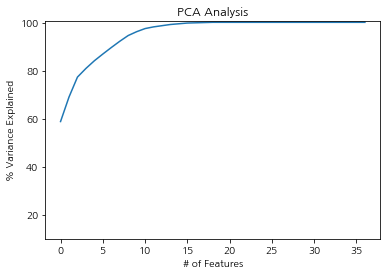

In [33]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(10,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

In [64]:
pca = PCA(n_components = 5)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
pca = PCA(copy=True, iterated_power='auto', n_components=5, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
X_reduced = pca.fit_transform(scale(X))

X_train = X_reduced[:3250] # 전체 rows의 70퍼센트
X_test = X_reduced[3250:]
y_train = y[:3250]
y_test = y[3250:]

X_train: (3250, 5)
y_train: (3250,)
X_test: (1392, 5)
y_test: (1392,)


선형회귀 분석 결과
lr.coef_: [16.29362093  0.0624755   1.58084609 -3.95683099  0.33190997]
lr.intercept_: 199.36717518456584
Mean squared error: 81.64
Variance score: 0.90


훈련 세트 점수: 0.99
테스트 세트 점수: 0.90




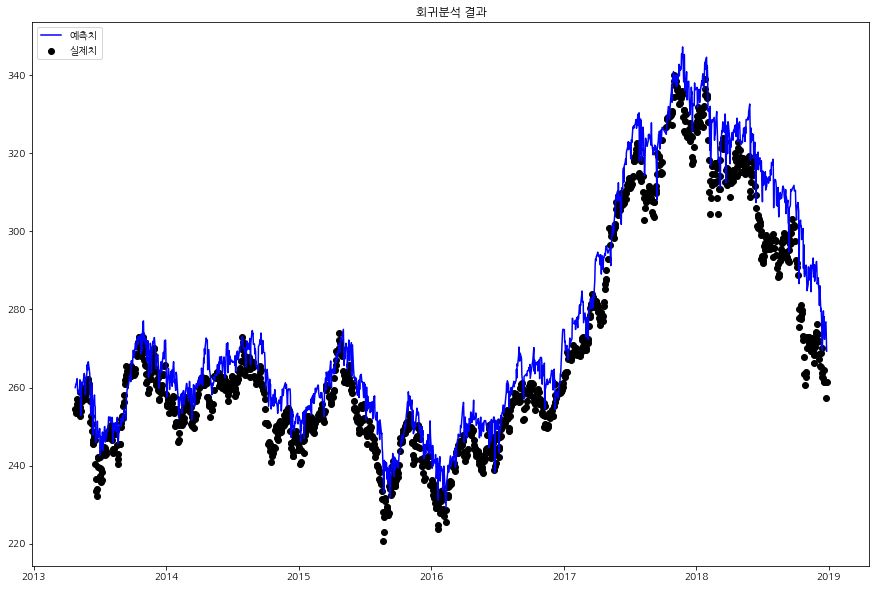

In [60]:
print("X_train: {}".format(str(X_train.shape))+'\n'+
      "y_train: {}".format(str(y_train.shape))+'\n'+
      "X_test: {}".format(str(X_test.shape))+'\n'+
      "y_test: {}".format(str(y_test.shape)))
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('\n')
print('선형회귀 분석 결과')
print("lr.coef_: {}".format(lr.coef_))

print("lr.intercept_: {}".format(lr.intercept_))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print('\n')
print("훈련 세트 점수: {:.2f}".format(lr.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lr.score(X_test, y_test)))
print('\n')
plt.figure(figsize=(15,10))
plt.scatter(y_test.index, y_test,  color='black', label = '실제치')
plt.plot(y_test.index, y_pred, color='blue', label = '예측치')
plt.title("회귀분석 결과")
plt.legend(loc=2)
plt.show()

Scaled_Ridge: 0.844314 (+/- 0.107165)
Scaled_Lasso: -4.070777 (+/- 6.204539)
Scaled_Elastic: -4.490945 (+/- 7.098809)
Scaled_RF_reg: 0.480192 (+/- 0.661723)
Scaled_ET_reg: 0.729652 (+/- 0.313970)
Scaled_BR_reg: 0.481067 (+/- 0.665216)
Scaled_Hub-Reg: 0.846281 (+/- 0.111576)
Scaled_BayRidge: 0.844561 (+/- 0.106932)
Scaled_XGB_reg: 0.536559 (+/- 0.539971)
Scaled_DT_reg: -0.121344 (+/- 1.406159)
Scaled_KNN_reg: -0.059538 (+/- 0.747847)
Scaled_Gboost-Reg: 0.528889 (+/- 0.528951)


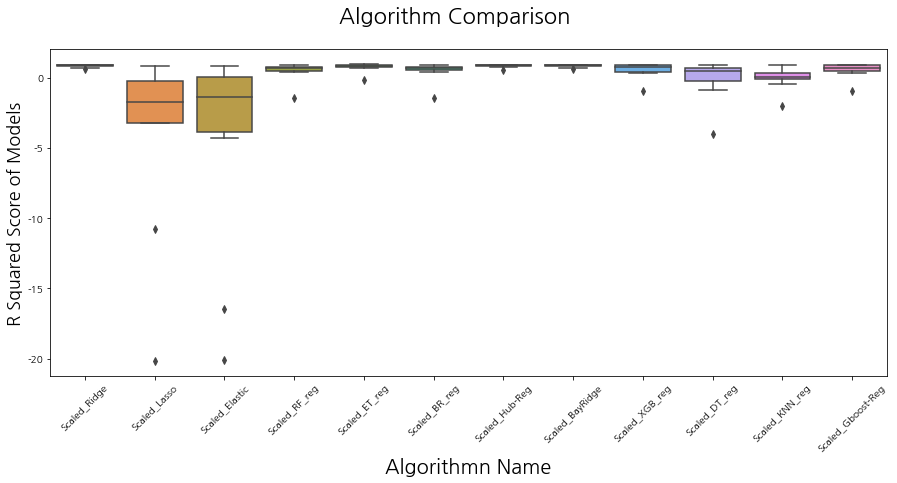

In [74]:
pca = PCA(copy=True, iterated_power='auto', n_components=5, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
X_reduced = pca.fit_transform(X)

X_train = X_reduced[:3250] # 전체 rows의 70퍼센트
X_test = X_reduced[3250:]
y_train = y[:3250]
y_test = y[3250:]

pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed, tol=10))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )


pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed))
                 ]))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))


scoring = 'r2'
n_folds = 10

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

# 상자그림을 이용해 알고리즘끼리의 성능 차이를 시각적으로 보여 쥽니다.
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

## 4-2. Classification

In [17]:
df_clf = df

In [18]:
df_clf['종가예측'] = df_clf['종가'].diff().shift(-1)
df_clf['종가예측'].fillna(0, inplace = True)

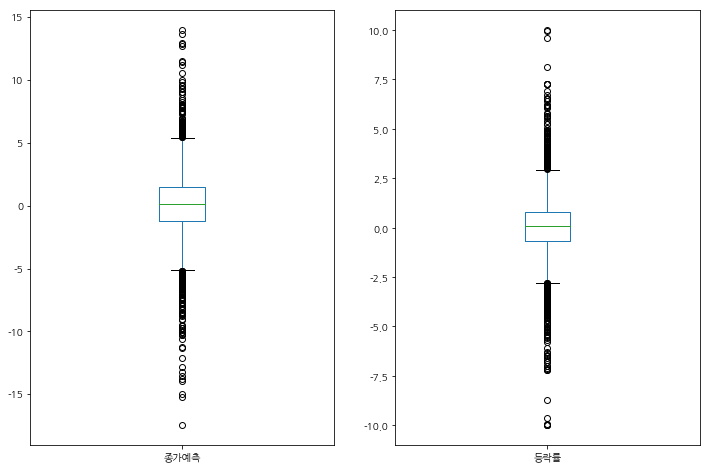

In [19]:
plt.subplot(1, 2, 1)
df_clf['종가예측'].plot.box(figsize=(12,8))
plt.subplot(1, 2, 2)
df_clf['등락률'].plot.box(figsize=(12,8))

In [78]:
df_clf['종가예측'].describe(), df_clf['등락률'].describe()

(count    4642.000000
 mean        0.031387
 std         2.614918
 min       -17.450000
 25%        -1.200000
 50%         0.150000
 75%         1.450000
 max        13.950000
 Name: 종가예측, dtype: float64, count    4642.000000
 mean        0.031801
 std         1.606257
 min       -10.000000
 25%        -0.660000
 50%         0.080000
 75%         0.777500
 max        10.000000
 Name: 등락률, dtype: float64)

In [20]:
# 타겟변수5 설정
df_clf['타겟변수5'] = pd.Series([])
df_clf.loc[(df_clf['종가예측'] >= 2), '타겟변수5'] = 2
df_clf.loc[((df_clf['종가예측'] > 0.5) & (df_clf['종가예측'] < 2)), '타겟변수5'] = 1
df_clf.loc[((df_clf['종가예측'] >= -0.5) & (df_clf['종가예측'] <= 0.5)), '타겟변수5'] = 0
df_clf.loc[((df_clf['종가예측'] > -2) & (df_clf['종가예측'] < -0.5)), '타겟변수5'] = -1
df_clf.loc[(df_clf['종가예측'] <= -2), '타겟변수5'] = -2

In [21]:
# 타겟변수2 설정
df_clf['타겟변수2'] = pd.Series([])
df_clf.loc[(df_clf['종가예측'] > 0), '타겟변수2'] = 1
df_clf.loc[(df_clf['종가예측'] <= 0), '타겟변수2'] = 0

In [22]:
# 타겟변수3 설정
df_clf['타겟변수3'] = pd.Series([])
df_clf.loc[(df_clf['종가예측'] > 1), '타겟변수3'] = 1
df_clf.loc[((df_clf['종가예측'] >= -1) & (df_clf['종가예측'] <= 1)), '타겟변수3'] = 0
df_clf.loc[(df_clf['종가예측'] < -1), '타겟변수3'] = -1

In [53]:
# missing value 표시기
missing = pd.DataFrame(df_clf.isnull().sum()).rename(columns = {0: 'total'})

missing['percent'] = missing['total'] / len(df_clf)

missing.sort_values('percent', ascending = False).head(10)

total  percent
시가        0      0.0
BB_L      0      0.0
30MA      0      0.0
35MA      0      0.0
40MA      0      0.0
45MA      0      0.0
50MA      0      0.0
55MA      0      0.0
60MA      0      0.0
BB_M      0      0.0

In [54]:
df_clf['타겟변수5'].value_counts()

 0.0    1122
 1.0    1085
 2.0     825
-1.0     823
-2.0     787
Name: 타겟변수5, dtype: int64

In [55]:
df_clf['타겟변수2'].value_counts()

1.0    2470
0.0    2172
Name: 타겟변수2, dtype: int64

In [56]:
df_clf['타겟변수3'].value_counts()

 0.0    1921
 1.0    1457
-1.0    1264
Name: 타겟변수3, dtype: int64

In [57]:
df_clf.head().transpose()

일자        2000-03-10    2000-03-13    2000-03-14    2000-03-15    2000-03-16
시가      1.145000e+02  1.100000e+02  1.038000e+02  1.024000e+02  1.070000e+02
고가      1.148500e+02  1.100000e+02  1.061500e+02  1.060000e+02  1.078500e+02
저가      1.115000e+02  1.038000e+02  1.034000e+02  1.003000e+02  1.039500e+02
종가      1.116000e+02  1.038000e+02  1.050000e+02  1.060000e+02  1.055000e+02
등락     -1.000000e+00 -1.000000e+00  1.000000e+00  1.000000e+00 -1.000000e+00
종가변화   -9.000000e-01 -7.800000e+00  1.200000e+00  1.000000e+00 -5.000000e-01
등락률    -8.000000e-01 -6.990000e+00  1.160000e+00  9.500000e-01 -4.700000e-01
거래량     5.365400e+04  5.189400e+04  5.798800e+04  6.630800e+04  5.900800e+04
미결제     1.833600e+04  1.797000e+04  1.911200e+04  2.471200e+04  2.611000e+04
증감      1.833600e+04 -3.660000e+02  1.142000e+03  5.600000e+03  1.398000e+03
거래대금    3.026661e+06  2.753537e+06  3.039295e+06  3.400235e+06  3.119567e+06
코스피200  1.106800e+02  1.051400e+02  1.043000e+02  1.032800e+02  1.041900e+02
현물등락    1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00  1.000000e+00
현물변화    8.700000e-01  5.540000e+00  8.400000e-01  1.020000e+00  9.100000e-01
Basis   9.200000e-01 -1.340000e+00  7.000000e-01  2.720000e+00  1.310000e+00
연도      2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03
월       3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00
일       1.000000e+01  1.300000e+01  1.400000e+01  1.500000e+01  1.600000e+01
요일      4.000000e+00  0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00
5MA     1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
10MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
15MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
20MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
25MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
30MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
35MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
40MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
45MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
50MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
55MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
60MA    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
BB_M    1.116000e+02  1.077000e+02  1.068000e+02  1.066000e+02  1.063800e+02
BB_L    1.226309e+02  1.187309e+02  1.152000e+02  1.135051e+02  1.124404e+02
BB_H    1.005691e+02  9.666913e+01  9.840000e+01  9.969493e+01  1.003196e+02
ATR     3.350000e+00  7.800000e+00  2.750000e+00  5.700000e+00  3.900000e+00
fast_K  0.000000e+00  1.330769e+01  1.346154e+01  1.358974e+01  1.352564e+01
fast_D  0.000000e+00  1.330769e+01  1.338462e+01  1.345299e+01  1.347115e+01
slow_K  0.000000e+00  2.661538e+01  2.019231e+01  1.811966e+01  1.690705e+01
slow_D  0.000000e+00  2.661538e+01  2.340385e+01  2.164245e+01  2.045860e+01
종가예측   -7.800000e+00  1.200000e+00  1.000000e+00 -5.000000e-01  1.200000e+00
타겟변수5  -2.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
타겟변수2   0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
타겟변수3  -1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00

In [58]:
print(df_clf.columns)

Index(['시가', '고가', '저가', '종가', '등락', '종가변화', '등락률', '거래량', '미결제', '증감', '거래대금',
       '코스피200', '현물등락', '현물변화', 'Basis', '연도', '월', '일', '요일', '5MA', '10MA',
       '15MA', '20MA', '25MA', '30MA', '35MA', '40MA', '45MA', '50MA', '55MA',
       '60MA', 'BB_M', 'BB_L', 'BB_H', 'ATR', 'fast_K', 'fast_D', 'slow_K',
       'slow_D', '종가예측', '타겟변수5', '타겟변수2', '타겟변수3'],
      dtype='object')


In [82]:
df_clf.to_csv('data/daily_futures.csv')

### LinearSVC
* row 수가 100K 미만

In [25]:
# 카테고리 분류(100000건 이하 데이터) -> LinearSVC 분류
from sklearn.svm import LinearSVC
warnings.filterwarnings('ignore') # 경고문 X

X = df_clf.drop(['타겟변수5', '타겟변수2', '타겟변수3', '종가예측'], axis = 1)
y = df_clf['타겟변수3']
X_train = X[:3250] # 전체 rows의 70퍼센트
X_test = X[3250:]
y_train = y[:3250]
y_test = y[3250:]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lsvc = LinearSVC(C=0.8)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)

print("훈련 세트 점수: {:.2f}".format(lsvc.score(X_train_scaled, y_train)))
print("테스트 세트 점수: {:.2f}".format(lsvc.score(X_test_scaled, y_test)))

훈련 세트 점수: 0.39
테스트 세트 점수: 0.46


### KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

X = df_clf.drop(['타겟변수5', '타겟변수2', '타겟변수3', '종가예측'], axis = 1)
y = df_clf['타겟변수3']
X_train = X[:3250] # 전체 rows의 70퍼센트
X_test = X[3250:]
y_train = y[:3250]
y_test = y[3250:]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

print("훈련 세트 점수: {:.2f}".format(knc.score(X_train_scaled, y_train)))
print("테스트 세트 점수: {:.2f}".format(knc.score(X_test_scaled, y_test)))

훈련 세트 점수: 0.28
테스트 세트 점수: 0.25


## SVC

In [26]:
from sklearn.svm import SVC

X = df_clf.drop(['타겟변수5', '타겟변수2', '타겟변수3', '종가예측'], axis = 1)
y = df_clf['타겟변수3']
X_train = X[:3250] # 전체 rows의 70퍼센트
X_test = X[3250:]
y_train = y[:3250]
y_test = y[3250:]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(kernel='rbf', C=1000, gamma=0.01)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)

print("훈련 세트 점수: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 점수: {:.2f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 점수: 0.48
테스트 세트 점수: 0.44


In [31]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4642 entries, 2000-03-10 to 2018-12-26
Data columns (total 43 columns):
시가        4642 non-null float64
고가        4642 non-null float64
저가        4642 non-null float64
종가        4642 non-null float64
등락        4642 non-null int32
종가변화      4642 non-null float64
등락률       4642 non-null float64
거래량       4642 non-null int32
미결제       4642 non-null int32
증감        4642 non-null int32
거래대금      4642 non-null float64
코스피200    4642 non-null float64
현물등락      4642 non-null int32
현물변화      4642 non-null float64
Basis     4642 non-null float64
연도        4642 non-null int64
월         4642 non-null int64
일         4642 non-null int64
요일        4642 non-null int64
5MA       4642 non-null float64
10MA      4642 non-null float64
15MA      4642 non-null float64
20MA      4642 non-null float64
25MA      4642 non-null float64
30MA      4642 non-null float64
35MA      4642 non-null float64
40MA      4642 non-null float64
45MA      4642 non-null float

In [35]:
print("X_train: {}".format(str(X_train.shape))+'\n'+
      "y_train: {}".format(str(y_train.shape))+'\n'+
      "X_test: {}".format(str(X_test.shape))+'\n'+
      "y_test: {}".format(str(y_test.shape)))

X_train: (3250, 39)
y_train: (3250,)
X_test: (1392, 39)
y_test: (1392,)


In [71]:
svc.decision_function

<bound method BaseSVC.decision_function of SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

In [92]:
svc_df = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svc_df.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)

print("훈련 세트 점수: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 점수: {:.2f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 점수: 0.48
테스트 세트 점수: 0.44


In [75]:
from sklearn.model_selection import GridSearchCV

print("Fitting the classifier to the training set")
t0 = time.time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
grid = grid.fit(X_train_scaled, y_train)
print("done in %0.3fs" % (time.time() - t0))
print("Best estimator found by grid search:")
print(grid.best_estimator_)

print("훈련 세트 점수: {:.2f}".format(grid.score(X_train_scaled, y_train)))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Fitting the classifier to the training set
done in 2030.555s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
훈련 세트 점수: 0.44
테스트 세트 점수: 0.40


## Tree & Ensemble

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

dtc = DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state=0)
scores = cross_val_score(dtc, X_train_scaled, y_train, cv=5)
print(scores.mean())
dtc.fit(X_train_scaled, y_train)
print("훈련 세트 정확도: {:.3f}".format(dtc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(dtc.score(X_test_scaled, y_test)))

rfc = RandomForestClassifier(n_estimators=10, max_depth=4, min_samples_split=2, random_state=0)
scores = cross_val_score(rfc, X_train_scaled, y_train, cv=5)
print(scores.mean())
rfc.fit(X_train_scaled, y_train)
print("훈련 세트 정확도: {:.3f}".format(rfc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rfc.score(X_test_scaled, y_test)))

etc = ExtraTreesClassifier(n_estimators=10, max_depth=6, min_samples_split=2, random_state=0)
scores = cross_val_score(etc, X_train_scaled, y_train, cv=5)
print(scores.mean())
etc.fit(X_train_scaled, y_train)
print("훈련 세트 정확도: {:.3f}".format(etc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(etc.score(X_test_scaled, y_test)))

0.23537071712686802
훈련 세트 정확도: 0.458
테스트 세트 정확도: 0.378
0.24768454071898577
훈련 세트 정확도: 0.482
테스트 세트 정확도: 0.445
0.24704978782835535
훈련 세트 정확도: 0.521
테스트 세트 정확도: 0.378


## LightGBM

In [78]:
#시작부분 코드
import time
start_time = time.time() 
#------------------------

import lightgbm as lgb
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore') # 경고문 X

lgbm=lgb.LGBMClassifier(n_estimators=1000, class_weight="balanced", reg_alpha=0.1, reg_lambda=0.1, learning_rate=0.01, num_leaves=200,
                        random_state=523)
lgbm_scores=cross_val_score(lgbm, X_train_scaled, y_train, cv=10)
print(lgbm_scores)
print("accuracy 평균 점수는 %.2f" %np.mean(lgbm_scores),"+/- %.2f"%np.std(lgbm_scores))

lgbm.fit(X_train_scaled, y_train)
y_pred=lgbm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
#----------------------------
#종료부분 코드
print("--- %s seconds ---" %(time.time() - start_time))

[0.38343558 0.25153374 0.12269939 0.05521472 0.06748466 0.05230769
 0.02469136 0.08950617 0.24382716 0.30650155]
accuracy 평균 점수는 0.16 +/- 0.12
             precision    recall  f1-score   support

       -1.0       0.28      0.51      0.36       348
        0.0       0.54      0.37      0.44       646
        1.0       0.29      0.23      0.25       398

avg / total       0.40      0.36      0.37      1392

--- 527.1705074310303 seconds ---


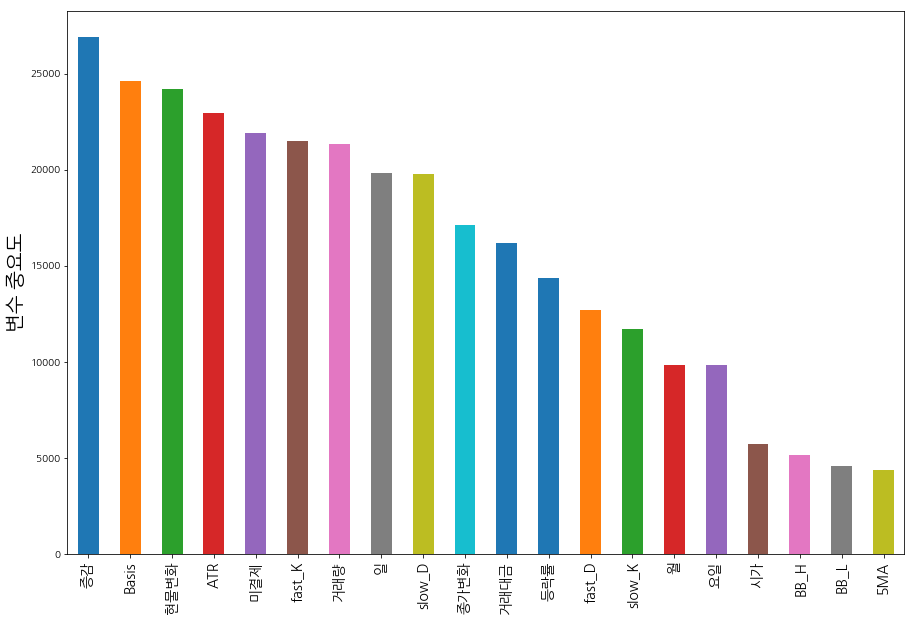

In [79]:
fi=pd.Series(dict(zip(X_test.columns,lgbm.feature_importances_)))
plt.figure(figsize=(15,10))
plt.ylabel("변수 중요도", fontsize=20)
plt.xticks(fontsize=14, rotation=90)
fi.nlargest(20).plot(kind="bar");

In [ ]:
# 거래량의 변화, 현물 가격의 변화 관련 변수들이 가장 높은 관련성을 보이는 것을 확인할 수 있습니다. 

## 4-3. Time Series

### SARIMAX

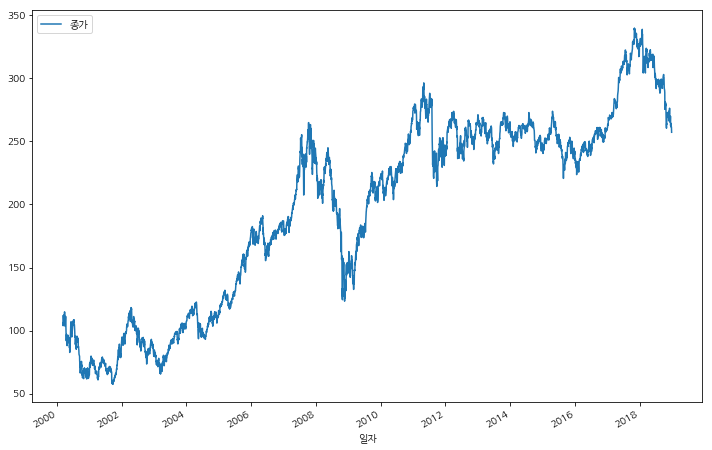

In [80]:
ts = pd.DataFrame(df.종가)
ts.plot(figsize=(12,8))

In [21]:
ts.isna().sum()

종가    0
dtype: int64

In [22]:
ts.index.min(), ts.index.max()

(Timestamp('2000-03-10 00:00:00'), Timestamp('2018-12-26 00:00:00'))

In [81]:
series = ts['종가']

<Figure size 1080x720 with 0 Axes>

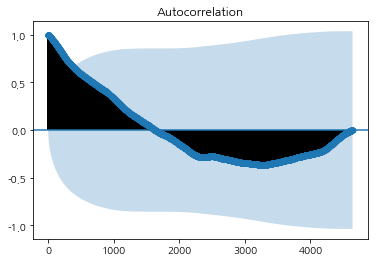

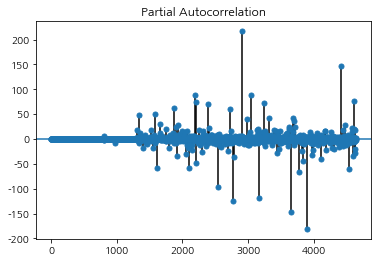

In [42]:
import statsmodels.api as sm

fig = plt.figure(figsize=(15,10))
sm.graphics.tsa.plot_acf(series)
sm.graphics.tsa.plot_pacf(series)
plt.show()

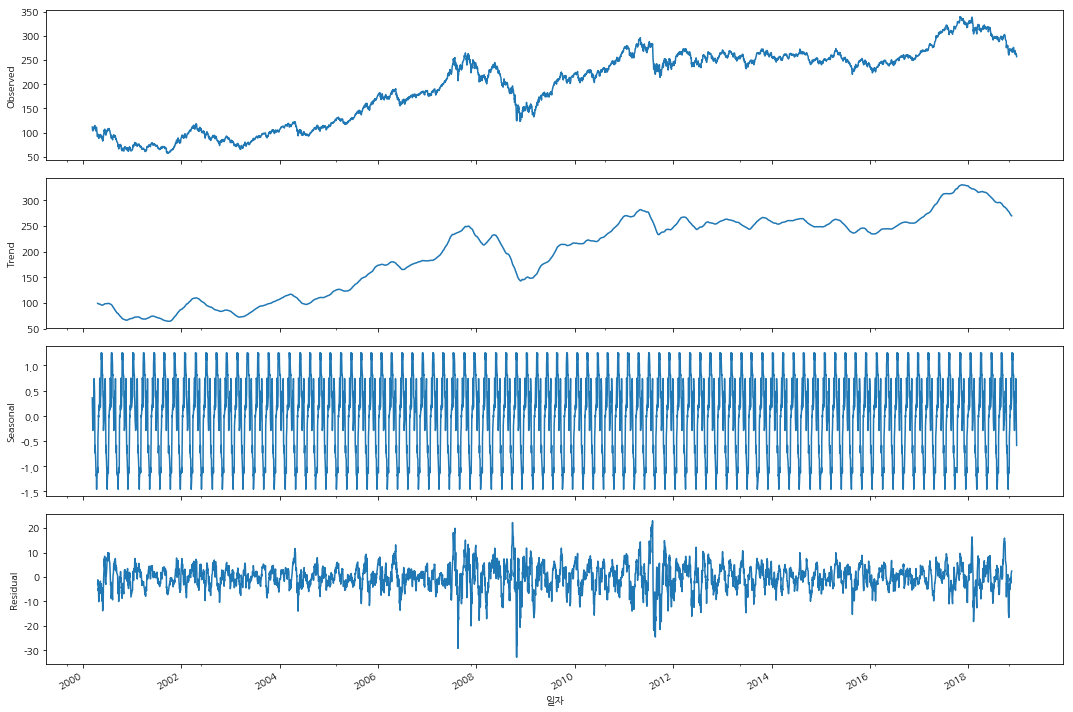

In [82]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(series, freq = 52, model='additive')
fig = decomposition.plot()
plt.show()

In [84]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [85]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:62861.36345655518
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:56597.42159896657
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:33070.57585603949
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:32982.984840280435
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:33076.72161199516
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:33066.78515179375
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:32995.05287633508
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:32984.978782397564


C:\Users\veror\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:56513.05601817629
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:50344.094191490745
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:29124.593994009094
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:28939.62187438389
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:29140.07372690123


C:\Users\veror\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:29278.93173492866
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:28969.148774173045
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:28937.819815581315
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22082.756429666646
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:22033.756308205888
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:25258.885848653754
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:22033.18375116506
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:22038.14449949541
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:22035.38367447053
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:23862.96081418106
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:22035.17675355162
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:22078.615834170523
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:22029.43999129148
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:25253.042256257526
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:22029.46604168799
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:22038.049562708904
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:22029.97241312617
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:23862.930158687297
A

C:\Users\veror\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:22097.334467396504


C:\Users\veror\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:22046.164043374054
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:25053.546194470364
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:22040.246062777303
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:22040.05668261773
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:22041.289789372437
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:23729.56442100493
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:22041.99645962072
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:22084.468823370295


C:\Users\veror\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:22045.377350927323
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:25041.34172566666
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:22033.95655554335
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:22039.941259420124
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:22036.47471393976
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:23731.302572324028
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:22035.932899547555
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:22082.546706945694
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:22033.674177387136
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:25258.05268003148
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:22033.645632486187
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:22033.682407140837
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:22034.24936863439
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:23856.112953526484
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:22034.95181210889
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22080.60429660524
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:22031.426846670067
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:25255.040566159252

In [ ]:
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:22029.257477020656 -> AIC 최소값

In [86]:
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7889      0.128      6.151      0.000       0.538       1.040
ma.L1         -0.8055      0.123     -6.538      0.000      -1.047      -0.564
ma.S.L12      -1.0001      0.213     -4.706      0.000      -1.417      -0.584
sigma2         6.8215      1.460      4.672      0.000       3.960       9.683


In [87]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                 종가   No. Observations:                 4642
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -11010.629
Date:                            Thu, 21 Feb 2019   AIC                          22029.257
Time:                                    15:31:34   BIC                          22055.006
Sample:                                         0   HQIC                         22038.319
                                           - 4642                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7889      0.128      6.151      0.000       0.538       1.040
ma.L1         -0.8055      0.123   

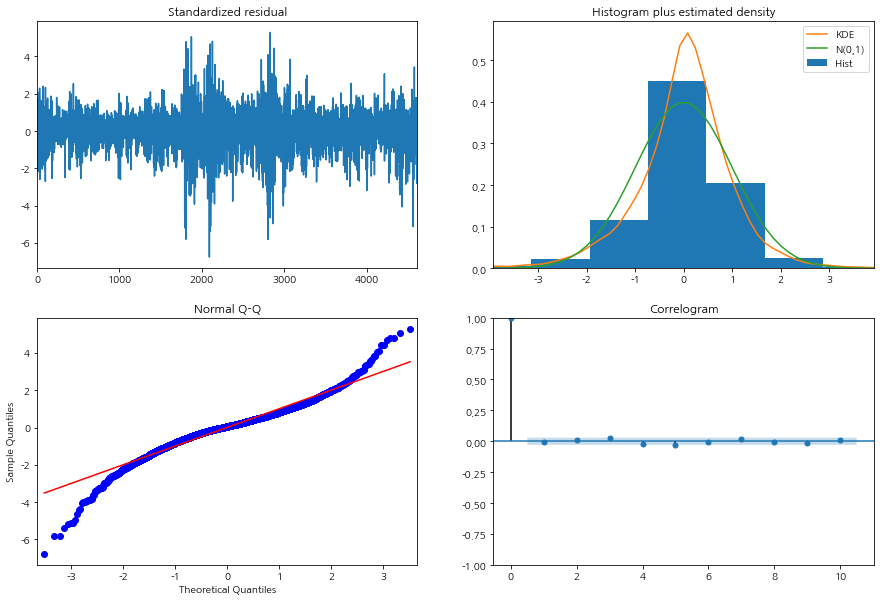

In [26]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
# pred = results.get_prediction(start=series.index.get_loc(pd.to_datetime('2018-01-02')), dynamic=False)

In [88]:
pred = results.get_prediction(start=series.index.get_loc(pd.to_datetime('2018-01-02')), dynamic=False)
pred_ci = pred.conf_int()
ax = series['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Future price')
plt.legend()
plt.show()

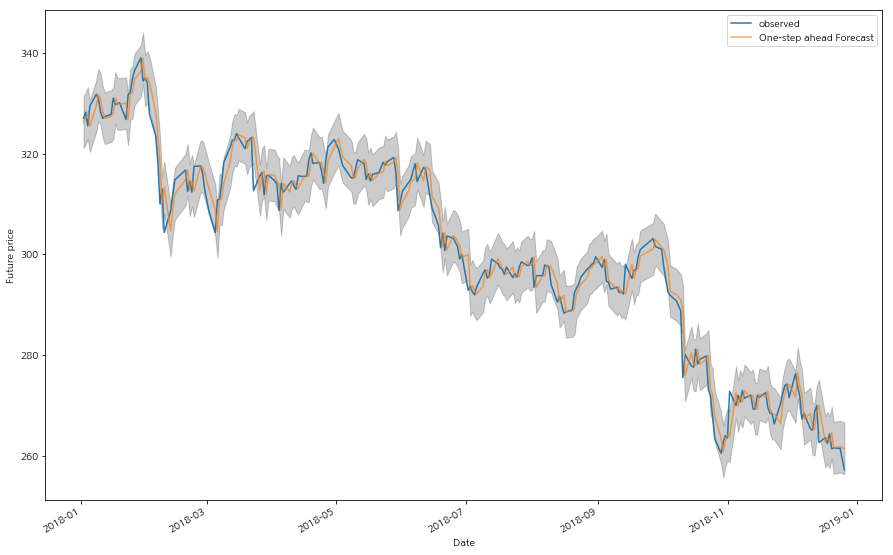

In [89]:
pred = results.get_prediction(start=series.index.get_loc(pd.to_datetime('2018-01-02')), dynamic=False)
pred_ci = pred.conf_int()
ax = series['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Future price')
plt.legend()
plt.show()

In [90]:
series_forecasted = pred.predicted_mean
series_truth = series['2018-01-01':]
mse = ((series_forecasted - series_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 8.75
The Root Mean Squared Error of our forecasts is 2.96


In [ ]:
# 앞으로 진행할 SARIMAX 분석에서 index값이 일정치 않아 오류가 발생하기 때문에 새로 indexing을 생성하여 적용합니다.

In [92]:
# 휴장일
df_hdays = pd.read_excel('data/data.xls') # 출처 http://marketdata.krx.co.kr/contents/MKD/01/0110/01100305/MKD01100305.jsp
hdays = df_hdays['일자 및 요일'].str.extract('(\d{4}-\d{2}-\d{2})', expand=False)
hdays = pd.to_datetime(hdays)
hdays.name = '휴장일'
hdays

0    2019-01-01
1    2019-02-04
2    2019-02-05
3    2019-02-06
4    2019-03-01
5    2019-05-01
6    2019-05-06
7    2019-06-06
8    2019-08-15
9    2019-09-12
10   2019-09-13
11   2019-10-03
12   2019-10-09
13   2019-12-25
14   2019-12-31
Name: 휴장일, dtype: datetime64[ns]

In [93]:
# 개장일
mdays = pd.date_range('2018-12-27', '2019-12-31')
mdays = pd.date_range('2018-12-27', '2019-12-31', freq='B')
mdays = mdays.drop(hdays)

In [94]:
# 시계열 분석을 통한 21일치 예측
pred_uc = results.get_forecast(steps=21)
pred_uc.predicted_mean = pred_uc.predicted_mean.reset_index().set_index(mdays[:21])
pred_uc.predicted_mean.drop(pred_uc.predicted_mean.columns[[0]], 1, inplace = True)
pred_uc.predicted_mean = pred_uc.predicted_mean[0]

pred_ci = pred_uc.conf_int()
pred_ci = pred_ci.reset_index().set_index(mdays[:21])
pred_ci.drop(pred_ci.columns[[0]], 1, inplace = True)

ax = series['2018-11-01':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Future price')
plt.legend()
plt.show()

### Prophet

In [99]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

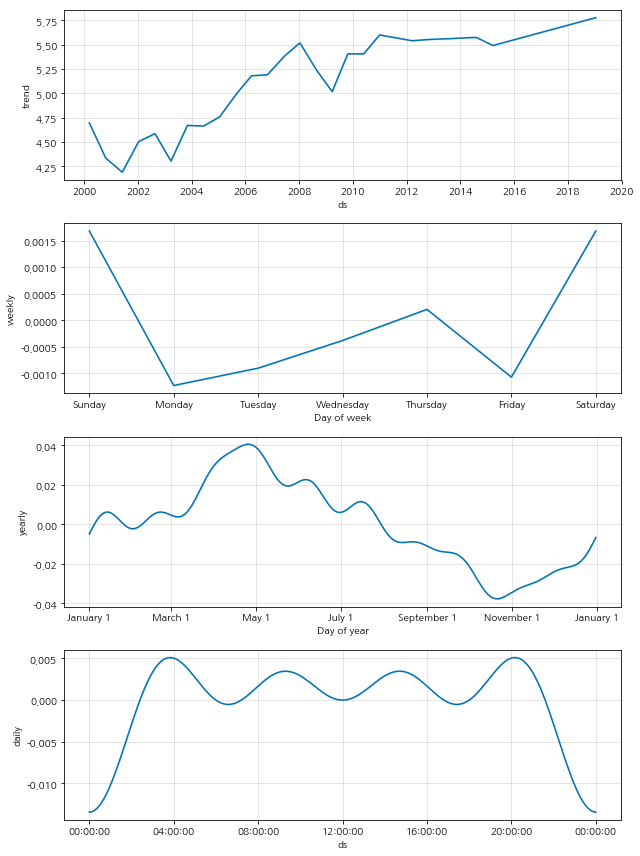

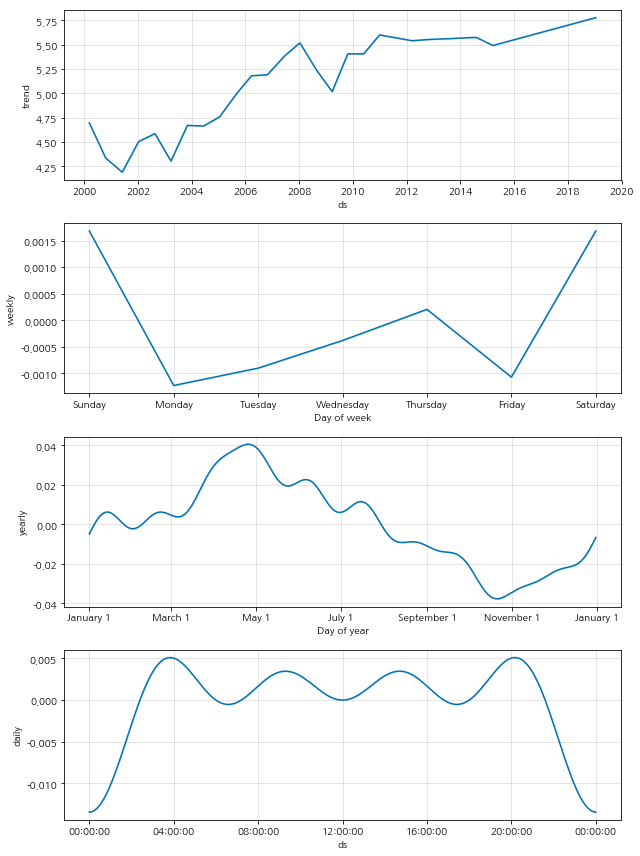

In [100]:
ts = pd.DataFrame(df.종가)
ts['종가'] = np.log(ts['종가'])
ts = ts.reset_index()
ts.rename(columns={'일자':'ds', '종가':'y'}, inplace = True)
m = Prophet(daily_seasonality=True)
m.fit(ts)
future = m.make_future_dataframe(periods=21)
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

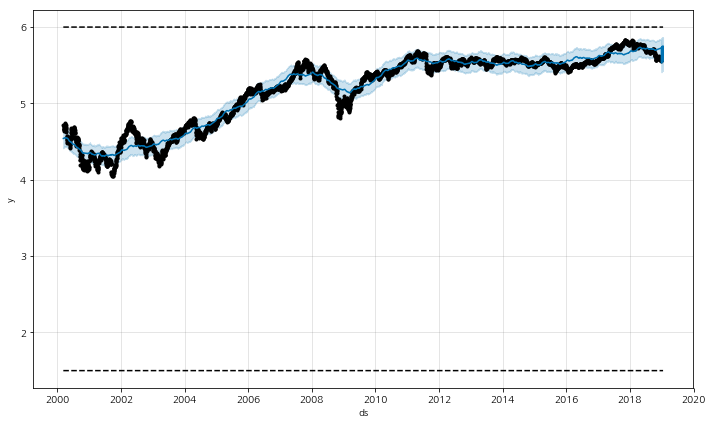

In [103]:
# Saturating Minimum
ts['y'] = 10 - ts['y']
ts['cap'] = 6
ts['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(daily_seasonality=True, growth='logistic')
m.fit(ts)
fcst = m.predict(future)
fig = m.plot(fcst)

In [105]:
# forecasting growth(capicity)
ts['cap'] = 8.5
m = Prophet(daily_seasonality=True, growth='logistic')
m.fit(ts)
future = m.make_future_dataframe(periods=21)
future['cap'] = 8.5
future['floor'] = 1.5
fcst = m.predict(future)
m.plot(fcst)

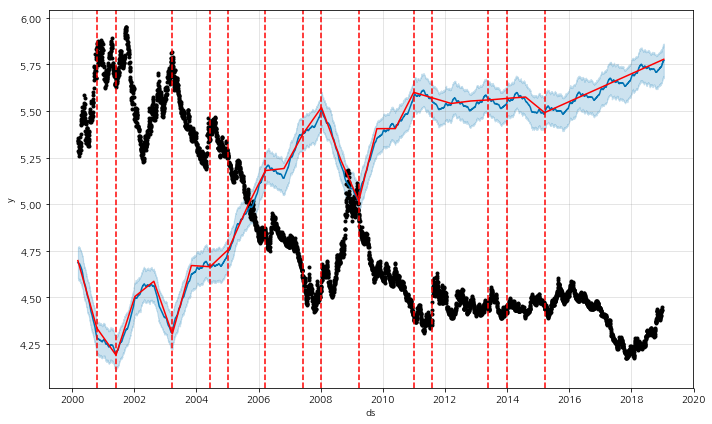

In [36]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [106]:
m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5)
forecast = m.fit(ts).predict(future)
fig = m.plot(forecast)

In [107]:
m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.001)
forecast = m.fit(ts).predict(future)
fig = m.plot(forecast)

In [108]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.tail()

INFO:fbprophet:Making 33 forecasts with cutoffs between 2002-03-20 00:00:00 and 2017-12-26 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
8155 2018-12-19  5.666796    5.484626    5.851966  5.577652 2017-12-26
8156 2018-12-20  5.668886    5.490340    5.836414  5.566243 2017-12-26
8157 2018-12-21  5.668321    5.491292    5.844739  5.567008 2017-12-26
8158 2018-12-24  5.666915    5.488488    5.833391  5.566625 2017-12-26
8159 2018-12-26  5.668953    5.499380    5.847488  5.550243 2017-12-26

In [109]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape  coverage
2254 37 days  0.034731  0.186364  0.141980  0.028097  0.768382
517  37 days  0.034680  0.186226  0.141878  0.028080  0.768382
7940 37 days  0.034693  0.186262  0.141922  0.028086  0.767157
2990 37 days  0.034736  0.186375  0.142095  0.028118  0.765931
1255 37 days  0.034790  0.186522  0.142313  0.028166  0.764706

## 4-4. Deep Learning

In [47]:
plot_x = df.index
plot_y = df['종가']
plt.plot(plot_x, plot_y)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [88]:
import keras

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

from sklearn.preprocessing import MinMaxScaler

look_back = 21

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = pd.np.array(df['종가']).reshape(4642,1)
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:2500]
val = signal_data[2500:3570]
test = signal_data[3570:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### MLP

Train on 2479 samples, validate on 1049 samples
Epoch 1/200
2479/2479 [==============================] - 0s 107us/step - loss: 0.0238 - val_loss: 0.0316
Epoch 2/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0112 - val_loss: 0.0347
Epoch 3/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0100 - val_loss: 0.0217
Epoch 4/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0087 - val_loss: 0.0253
Epoch 5/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0084 - val_loss: 0.0514
Epoch 6/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0076 - val_loss: 0.0522
Epoch 7/200
2479/2479 [==============================] - 0s 30us/step - loss: 0.0076 - val_loss: 0.0377
Epoch 8/200
2479/2479 [==============================] - 0s 29us/step - loss: 0.0070 - val_loss: 0.0444
Epoch 9/200
2479/2479 [==============================] - 0s 28us/step - loss: 0.0068 - val_loss: 0.0519
Epoch 10/200
24

Train Score:  0.00811873679594056
Validataion Score:  0.04622693615898959
Test Score:  0.060281148954843135


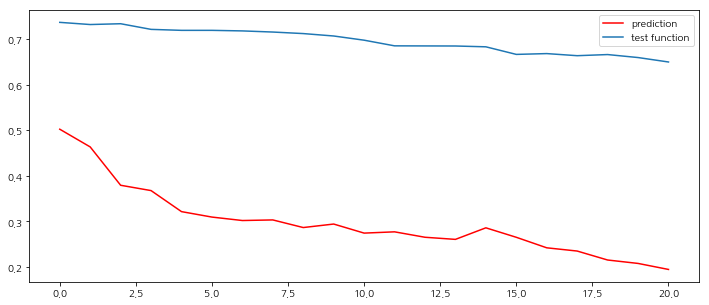

In [81]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# 데이터셋 전처리
x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

# 모델 구성하기
model1 = Sequential()
model1.add(Dense(32,input_dim=21,activation="relu"))
model1.add(Dropout(0.3))
for i in range(2):
    model1.add(Dense(32,activation="relu"))
    model1.add(Dropout(0.3))
model1.add(Dense(1))

# 모델 학습과정 설정하기
model1.compile(loss='mean_squared_error', optimizer='adagrad')

# 모델 학습시키기
hist1 = model1.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 학습과정 살펴보기
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
          
# 모델 평가하기
trainScore = model1.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model1.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model1.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

# 모델 사용하기
look_ahead = 21
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model1.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

### LSTM

Train on 2479 samples, validate on 1049 samples
Epoch 1/200
2479/2479 [==============================] - 1s 558us/step - loss: 0.0138 - val_loss: 7.9692e-04
Epoch 2/200
2479/2479 [==============================] - 1s 215us/step - loss: 0.0035 - val_loss: 7.0503e-04
Epoch 3/200
2479/2479 [==============================] - 1s 218us/step - loss: 0.0029 - val_loss: 4.0326e-04
Epoch 4/200
2479/2479 [==============================] - 1s 210us/step - loss: 0.0024 - val_loss: 3.4051e-04
Epoch 5/200
2479/2479 [==============================] - 1s 210us/step - loss: 0.0020 - val_loss: 8.1066e-04
Epoch 6/200
2479/2479 [==============================] - 1s 215us/step - loss: 0.0019 - val_loss: 3.2802e-04
Epoch 7/200
2479/2479 [==============================] - 1s 215us/step - loss: 0.0018 - val_loss: 7.4389e-04
Epoch 8/200
2479/2479 [==============================] - 1s 217us/step - loss: 0.0015 - val_loss: 7.6352e-04
Epoch 9/200
2479/2479 [==============================] - 1s 217us/step - loss: 0

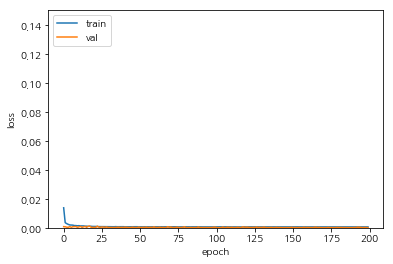

Train Score:  9.024965627908916e-05
Validataion Score:  0.00012473092011923594
Test Score:  8.75879063706962e-05


In [84]:
# 모델 구성하기
model2 = Sequential()
model2.add(LSTM(32, input_shape=(None, 1)))
model2.add(Dropout(0.3))
model2.add(Dense(1))

# 모델 학습과정 설정하기
model2.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습시키기
hist2 = model2.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 학습과정 살펴보기
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 모델 평가하기
trainScore = model2.evaluate(x_train, y_train, verbose=0)
model2.reset_states()
print('Train Score: ', trainScore)
valScore = model2.evaluate(x_val, y_val, verbose=0)
model2.reset_states()
print('Validataion Score: ', valScore)
testScore = model2.evaluate(x_test, y_test, verbose=0)
model2.reset_states()
print('Test Score: ', testScore)

# 모델 사용하기
look_ahead = 21
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model2.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 5ms/step - loss: 0.0012 - val_loss: 0.0050
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 4ms/step - loss: 0.0013 - val_loss: 0.0046
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 4ms/step - loss: 0.0014 - val_loss: 0.0061
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 4ms/step - loss: 0.0012 - val_loss: 0.0047
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 4ms/step - loss: 0.0011 - val_loss: 0.0031
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [==============================] - 11s 4ms/step - loss: 9.8123e-04 - val_loss: 0.0028
Train on 2479 samples, validate on 1049 samples
Epoch 1/1
2479/2479 [===========================

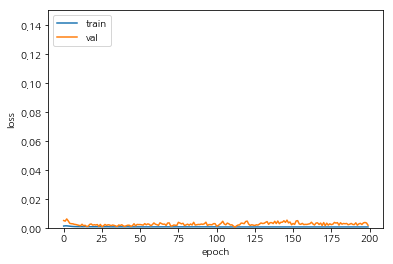

Train Score:  0.010004894105022014
Validataion Score:  0.0017676483475727257
Test Score:  0.005442067658745016


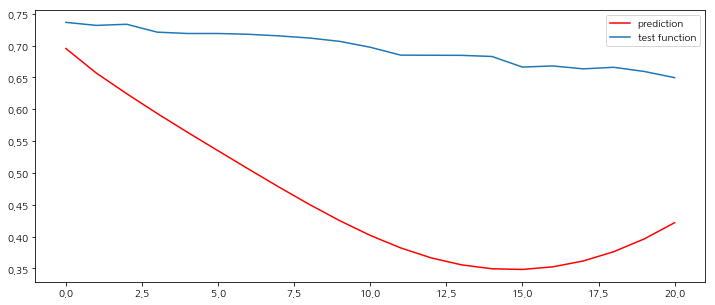

In [87]:
# 모델 구성하기
model3 = Sequential()
model3.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model3.add(Dropout(0.3))
model3.add(Dense(1))

# 모델 학습과정 설정하기
model3.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습시키기
start_vect=time.time()
#------------------------
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model3.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model3.reset_states()

# 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#------------------------
print("training Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# 모델 평가하기
trainScore = model3.evaluate(x_train, y_train, batch_size=1, verbose=0)
model3.reset_states()
print('Train Score: ', trainScore)
valScore = model3.evaluate(x_val, y_val, batch_size=1, verbose=0)
model3.reset_states()
print('Validataion Score: ', valScore)
testScore = model3.evaluate(x_test, y_test, batch_size=1, verbose=0)
model3.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 21
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model3.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()